In [ ]:
!pip install transformers

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup

In [ ]:
test_data = pd.read_csv("test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [ ]:
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


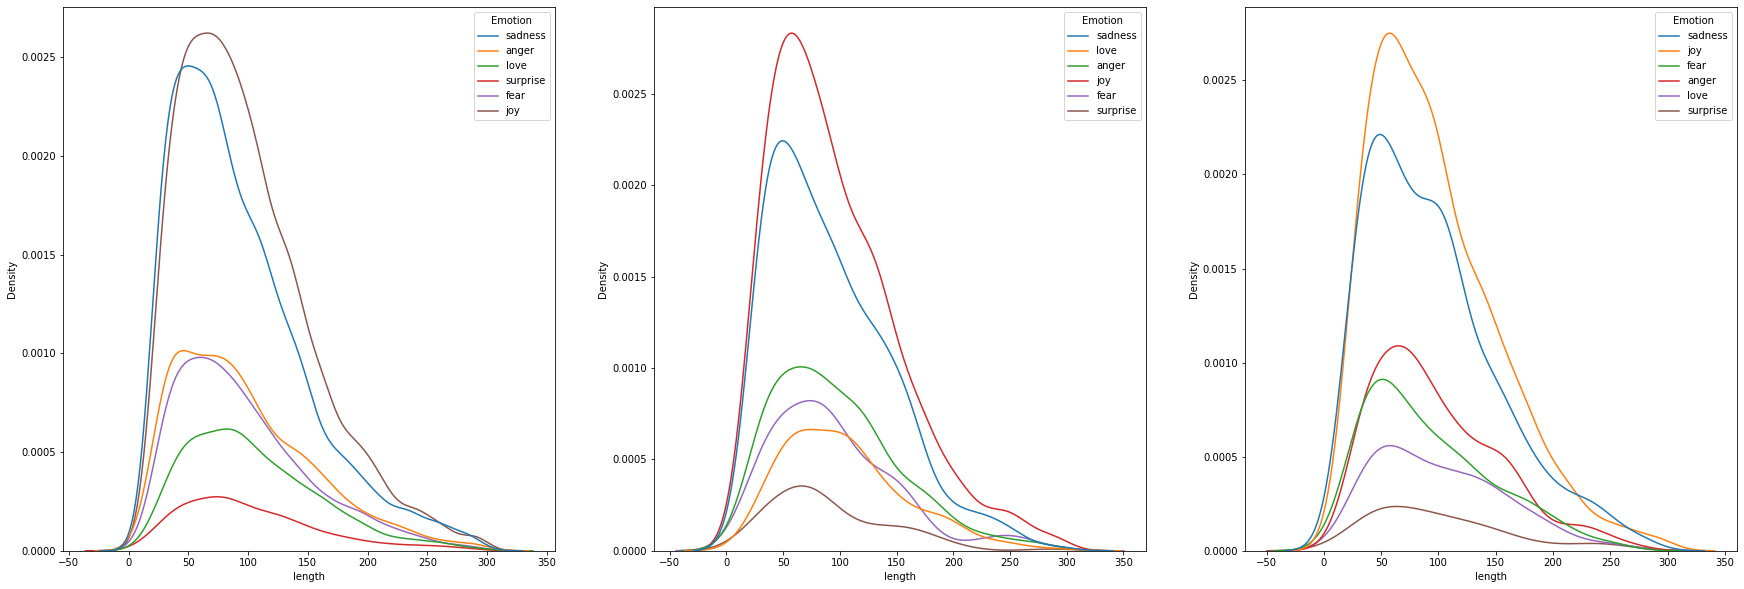

In [ ]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [ ]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");

In [ ]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

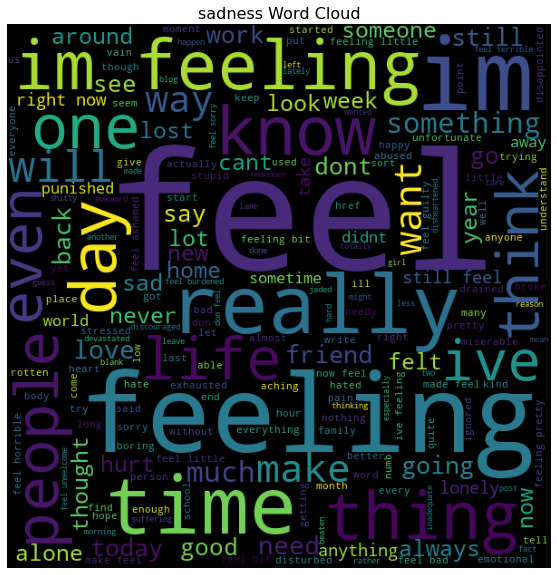

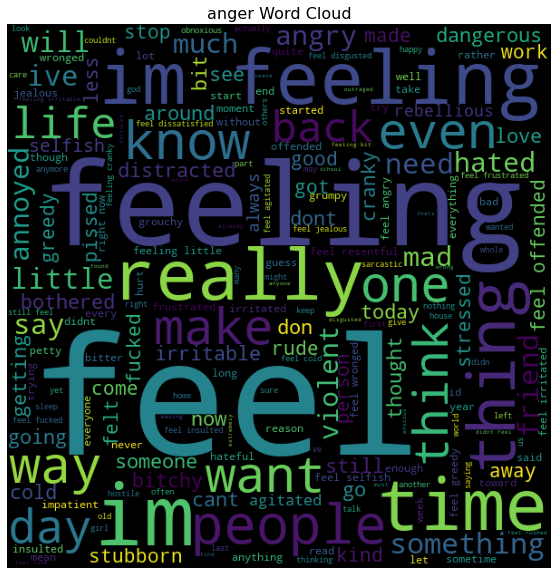

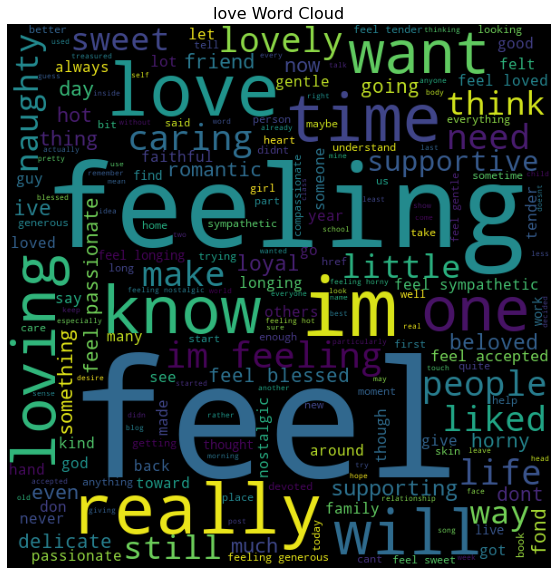

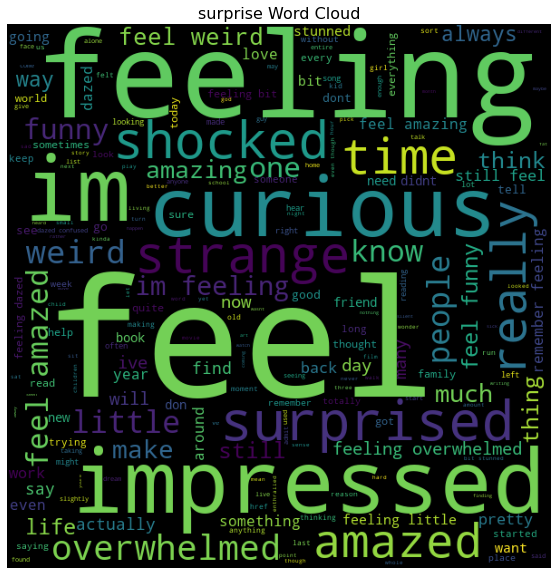

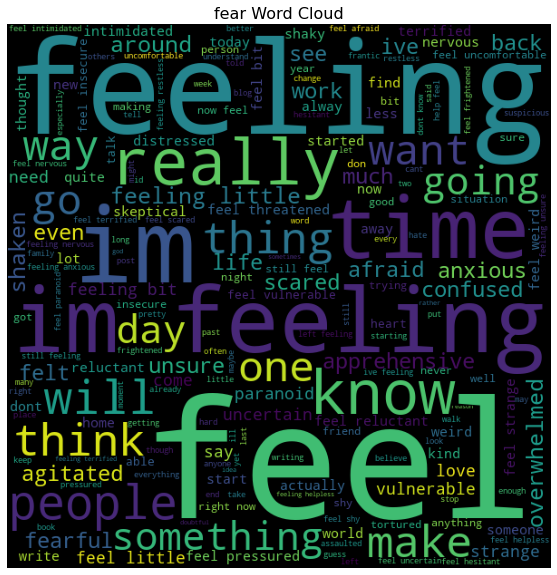

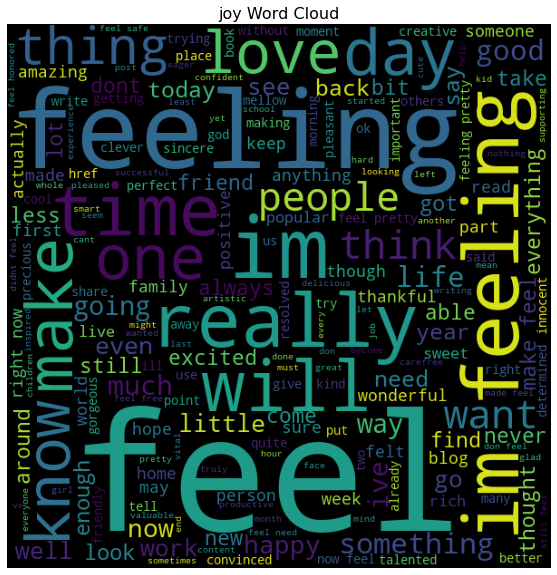

In [ ]:
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [ ]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

In [ ]:
train_data.head(2)

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108


In [ ]:
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
max_len=train_data['length'].max()
max_len

300

In [ ]:
vocabSize = 11000

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [ ]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [ ]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 150)          1650000   
                                                                 
 dropout_3 (Dropout)         (None, 300, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               142848    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                

In [ ]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [ ]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 175s 692ms/step - loss: 1.5437 - accuracy: 0.3812 - val_loss: 1.2138 - val_accuracy: 0.5570
Epoch 2/10
250/250 [==============================] - 175s 699ms/step - loss: 0.7750 - accuracy: 0.7193 - val_loss: 0.5078 - val_accuracy: 0.8440
Epoch 3/10
250/250 [==============================] - 176s 705ms/step - loss: 0.3284 - accuracy: 0.8957 - val_loss: 0.3226 - val_accuracy: 0.8895
Epoch 4/10
250/250 [==============================] - 175s 702ms/step - loss: 0.2069 - accuracy: 0.9297 - val_loss: 0.3077 - val_accuracy: 0.8935
Epoch 5/10
250/250 [==============================] - 172s 687ms/step - loss: 0.1588 - accuracy: 0.9461 - val_loss: 0.3567 - val_accuracy: 0.8895
Epoch 6/10
250/250 [==============================] - 167s 669ms/step - loss: 0.1257 - accuracy: 0.9563 - val_loss: 0.3615 - val_accuracy: 0.8825


In [ ]:
model.evaluate(x_val,y_val,verbose=1)

63/63 [==============================] - 5s 75ms/step - loss: 0.3643 - accuracy: 0.8790


[0.36426326632499695, 0.8790000081062317]

In [ ]:
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 5s 84ms/step - loss: 0.4034 - accuracy: 0.8625


[0.4034208059310913, 0.862500011920929]

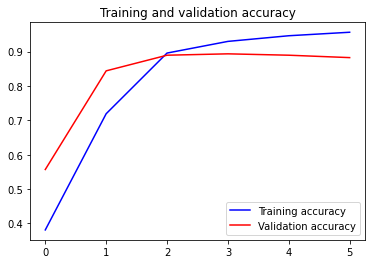

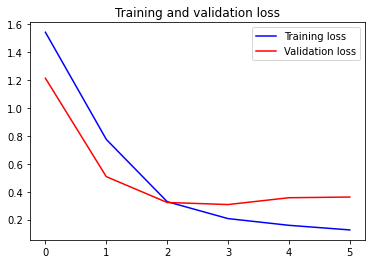

Accuracy :  [0.3812499940395355, 0.7192500233650208, 0.8957499861717224, 0.9296875, 0.9461249709129333, 0.9563124775886536]


In [ ]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print('Accuracy : ',accuracy)

In [ ]:
def sentence_cleaning(sentence):
    """Pre-processing sentence for prediction"""
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

In [ ]:
sentences = [
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "I was barely happy"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He was speechles when he found out he was accepted to this new job
anger : 0.3268255591392517


This is outrageous, how can you talk like that?
anger : 0.909544825553894


I feel like im all alone in this world
sadness : 0.9694511890411377


He is really sweet and caring
love : 0.8531857132911682


I was barely happy
joy : 0.6375061273574829


